### Setup

In [50]:
# External libraries used for various tasks in later parts of the code
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
from imutils import paths
import torch
import torch.nn as nn
import time
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm
import os

# Check if running on Google Colab and set the data paths accordingly
is_running_on_colab = 'COLAB_GPU' in os.environ
if is_running_on_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    train_path = '/content/gdrive/MyDrive/license_plate/CCPD/train/'
    val_path = '/content/gdrive/MyDrive/license_plate/CCPD/val/'
    test_path = '/content/gdrive/MyDrive/license_plate/CCPD/test/'

    train_danish_path = '/content/gdrive/MyDrive/license_plate/danish_license/train'
    val_danish_path = '/content/gdrive/MyDrive/license_plate/danish_license/val'
    test_danish_path = '/content/gdrive/MyDrive/license_plate/danish_license/test'
else:
    current_dir = os.getcwd()
    train_path = os.path.join(current_dir, 'dataset', 'license_plate', 'train')
    val_path = os.path.join(current_dir, 'dataset', 'license_plate', 'val')
    test_path = os.path.join(current_dir, 'dataset', 'license_plate', 'test')

# Function to check if directories exist
def check_directories_exist(*paths):
    for path in paths:
        assert os.path.isdir(path), f"The directory {path} does not exist."

# Check the directories
check_directories_exist(train_path, val_path, test_path, train_danish_path, val_danish_path, test_danish_path)

# Sets device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_PATH = [train_path]
VAL_PATH = [val_path]
TEST_PATH = [test_path]
TRAIN_DANISH_PATH = [train_danish_path]
VAL_DANISH_PATH = [val_danish_path]
TEST_DANISH_PATH = [test_danish_path]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Check how many images in data-split**

In [12]:
# Function to count files in a directory
def count_files_in_directory(directory):
    return len(os.listdir(directory))

# Check the number of files in each path
train_files = count_files_in_directory(train_path)
val_files = count_files_in_directory(val_path)
test_files = count_files_in_directory(test_path)
train_danish_files = count_files_in_directory(train_danish_path)

# Print the results
print(f"Number of files in train path: {train_files}")
print(f"Number of files in val path: {val_files}")
print(f"Number of files in test path: {test_files}")
print(f"Number of files in danish train path: {train_danish_files}")



Number of files in train path: 5769
Number of files in val path: 1001
Number of files in test path: 1310
Number of files in danish train path: 77


### DataLoader


In [13]:
from torch.utils.data import Dataset
import cv2
from imutils import paths
import os
import torch

class LabelFpsDataLoader(Dataset):
    def __init__(self, img_dirs, img_size, is_transform=None, normalize_labels=False):
        self.img_paths = [p for img_dir in img_dirs for p in paths.list_images(img_dir)]
        self.img_size = img_size
        self.is_transform = is_transform
        self.normalize_labels = normalize_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
        img = cv2.imread(img_name)
        resized_image = self.transform_image(img)

        file_name = os.path.splitext(os.path.basename(img_name))[0]
        labels = self.extract_labels(file_name, img.shape)

        return resized_image, labels, img_name

    def transform_image(self, img):
        resized_image = cv2.resize(img, self.img_size).astype('float32') / 255.0
        # Normalization - Adjust mean and std if necessary
        mean = np.array([0.485, 0.456, 0.406], dtype=resized_image.dtype)
        std = np.array([0.229, 0.224, 0.225],dtype=resized_image.dtype)

        resized_image = (resized_image - mean) / std  # Normalize
        return resized_image

    def extract_labels(self, file_name, img_shape):
        parts = file_name.split('-')
        points = [self.parse_point(part) for part in parts[2].split('_')]
        ori_w, ori_h = img_shape[1], img_shape[0]
        scale_w, scale_h = self.img_size[0] / ori_w, self.img_size[1] / ori_h
        scaled_points = [(int(x * scale_w), int(y * scale_h)) for x, y in points]
        if self.normalize_labels:
          scaled_points = [(x / self.img_size[0], y / self.img_size[1]) for x, y in scaled_points]
        flattened_labels = [coord for point in scaled_points for coord in point]
        return torch.tensor(flattened_labels, dtype=torch.float32)

    @staticmethod
    def parse_point(point_str):
        return tuple(int(coord) for coord in point_str.split('&'))


### Helper methods

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_img_and_boundingbox(image, labels, img_size):
    # Assuming image is a PyTorch tensor, we need to first move it to CPU if it's on GPU,
    # then detach it from the current graph, convert to numpy, and finally transpose it
    # from (channels, height, width) to (height, width, channels)
    numpy_array = image.cpu().detach().numpy()

    # Convert from BGR to RGB format if the image was read by OpenCV
    rgb_image = cv2.cvtColor(numpy_array, cv2.COLOR_BGR2RGB)

    # Extract numerical values from tensors and convert to integers
    left_up = (int(labels[0]*img_size), int(labels[1]*img_size))
    right_down = (int(labels[2]*img_size), int(labels[3]*img_size))

    # Draw rectangle on the image
    new_image = cv2.rectangle(rgb_image, left_up, right_down, (255, 0, 0), 2)

    # Display the image
    plt.imshow(new_image)
    plt.axis('off')  # Hide the axis
    plt.show()

# Example usage:
# img, labels, _ = dataset[0]  # Assuming this is how you get an image and labels from your dataset
# plot_img_and_boundingbox(img, labels)


In [15]:
def save_model(model):
    # Get the current time
    current_time = datetime.now()

    # Format the time in a 'YearMonthDay_HourMinuteSecond' format for the filename
    timestamp = current_time.strftime('%Y%m%d_%H%M')
    model_path = f'/content/gdrive/MyDrive/license_plate/models/model_weights_{timestamp}.pth'
    torch.save(model.state_dict(), model_path)

def load_model(path):
    model = get_new_model()
    model.load_state_dict(torch.load(path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    return model

In [16]:
def bb_intersection_over_union(boxA, boxB):
    # Compute the intersection over union on GPU
    # Assumes boxA and boxB are tensors
    xA = torch.max(boxA[..., 0], boxB[..., 0])
    yA = torch.max(boxA[..., 1], boxB[..., 1])
    xB = torch.min(boxA[..., 2], boxB[..., 2])
    yB = torch.min(boxA[..., 3], boxB[..., 3])

    interArea = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)

    boxAArea = (boxA[..., 2] - boxA[..., 0]) * (boxA[..., 3] - boxA[..., 1])
    boxBArea = (boxB[..., 2] - boxB[..., 0]) * (boxB[..., 3] - boxB[..., 1])

    iou = interArea / (boxAArea + boxBArea - interArea)
    return iou

def calculate_true_positives_in_batch(y_pred, y_batch, threshold=0.7):
    # Calculate IoU for the batch
    iou = bb_intersection_over_union(y_pred, y_batch)

    # Count true positives in the batch
    true_positives = torch.sum(iou > threshold).item()
    return true_positives

def calculate_loss_and_accuracy(loader, model, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_true_positives = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for X_batch, y_batch, _ in loader:
            X_batch = X_batch.permute(0,3,1,2).to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)

            total_true_positives += calculate_true_positives_in_batch(y_pred, y_batch)

            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item() * X_batch.size(0)  # Accumulate scaled loss
            total_samples += X_batch.size(0)  # Accumulate number of samples

    sample_loss = total_loss / total_samples  # Calculate average loss
    accuracy = total_true_positives / total_samples  # Calculate accuracy
    return sample_loss, accuracy

In [17]:
def check_requires_grad(model):
  for name, param in model.named_parameters():
    if name.startswith('classifier'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')
    if name.startswith('features'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')


In [18]:
import matplotlib.pylab as plt

def plot_history(history):
    eval_epochs = range(1, len(history['in_loss']) + 1)

    # Plot for loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(eval_epochs, history['in_loss'], 'b', label='In Loss')
    plt.plot(eval_epochs, history['out_loss'], 'r', label='Out Loss')
    plt.title('Loss')
    plt.xlabel('Epochs with evaluation')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(eval_epochs, history['in_acc'], 'b', label='In Acc')
    plt.plot(eval_epochs, history['out_acc'], 'r', label='Out Acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs with evaluation')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlapping

    plt.show()


### Model


In [25]:
import torch
import torch.nn as nn

# Function to create the modified classifier
def create_custom_classifier(input_features, hidden_units, output_features):
    classifier = nn.Sequential(
        # nn.Dropout(0.5),
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Dropout(0.0),
        #nn.BatchNorm1d(hidden_units),
        nn.Linear(hidden_units, output_features),
    )
    return classifier

# Load a pre-trained MobileNetV3 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)

def get_new_model():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)
    model.classifier = create_custom_classifier(input_features=960, hidden_units=100, output_features=4)

    # Set the model to evaluation mode if not training
    model.eval()

    # Number of layers you want to fine-tune
    layers_of_classifier = len(model.classifier)

    # Get all the parameters from the model as a list
    parameters = list(model.parameters())

    # The total number of layers is the length of the parameters list
    number_of_layers = len(parameters)

    # Calculate the number of pretrained layers (all except the last 'layers_of_classifier')
    pretrained_layers = number_of_layers - layers_of_classifier

    # Freeze the parameters of the pretrained base layers
    for param in parameters[:-layers_of_classifier]:
        param.requires_grad = False

    # Unfreeze the parameters of the last 'layers_of_classifier' layers
    for param in parameters[-layers_of_classifier:]:
        param.requires_grad = True
    model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return model
# model = get_new_model()
# check_requires_grad(model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


### Constants & dataset initialization

In [57]:
import torch
from torch.utils.data import DataLoader, Subset
from datetime import datetime
from tqdm import tqdm

# Constants
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

SUBSET_INDICES = 100
SUBSET_VAL_INDICES = 200
SUBSET_TEST_INDICES = 50

DECODER_EPOCHS = 10
#N_EPOCHS_CYCLIC = 10
N_EPOCHS_LINEAR = 100

USE_TQDM = True
USE_SUBSET = False
NORMALIZED_LABELS = True
EVAL_EVERY = 1

loss_fn = nn.MSELoss()

# Define dataloaders

# Training
train_dataset = LabelFpsDataLoader(TRAIN_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)

# Validation
val_dataset = LabelFpsDataLoader(VAL_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)

# Test
test_dataset = LabelFpsDataLoader(TEST_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=2)

# Danish
train_danish_dataset = LabelFpsDataLoader(TRAIN_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
train_danish_loader = DataLoader(train_danish_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle = True, num_workers=2)

val_danish_dataset = LabelFpsDataLoader(VAL_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
val_danish_loader = DataLoader(train_danish_dataset, batch_size=VAL_BATCH_SIZE, shuffle = True, num_workers=2)

test_danish_dataset = LabelFpsDataLoader(TEST_DANISH_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
test_danish_loader = DataLoader(train_danish_dataset, batch_size=TEST_BATCH_SIZE, shuffle = True, num_workers=2)


# Use subsets for faster iterations during development
if USE_SUBSET:
    # Training
    train_dataset = Subset(train_dataset, indices=range(SUBSET_INDICES))
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    # Validation
    val_dataset = Subset(val_dataset, indices=range(SUBSET_VAL_INDICES))
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)
    # Test
    test_dataset = Subset(test_dataset, indices=range(SUBSET_TEST_INDICES))
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=2)

### Training & test methods

In [21]:
import torch
from torch.utils.data import DataLoader, Subset
from datetime import datetime
from tqdm import tqdm

# Training functions
def train_epoch(dataloader, optimizer, model, loss_fn, scaler):
    for X_batch, y_batch, _ in dataloader:
        optimizer.zero_grad()
        X_batch = X_batch.permute(0, 3, 1, 2).to(device)
        y_batch = y_batch.to(device)
        with torch.cuda.amp.autocast():
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

def train_model(n_epochs, optimizer, scheduler, dataloader, val_loader, model, loss_fn):
    in_loss_history = []
    out_loss_history = []
    in_acc_history = []
    out_acc_history = []
    scaler = torch.cuda.amp.GradScaler()

    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_loss = train_epoch(dataloader, optimizer, model, loss_fn, scaler)
        scheduler.step()

        if epoch % EVAL_EVERY == 0:
            model.eval()
            with torch.no_grad():
                # In-sample
                in_sample_loss, in_sample_accuracy = calculate_loss_and_accuracy(dataloader, model, loss_fn, device)
                in_loss_history.append(in_sample_loss)
                in_acc_history.append(in_sample_accuracy)

                # Out-sample
                out_sample_loss, out_sample_accuracy = calculate_loss_and_accuracy(val_loader, model, loss_fn, device)
                out_loss_history.append(out_sample_loss)
                out_acc_history.append(out_sample_accuracy)

                if USE_TQDM:
                    tqdm.write(f'Epoch {epoch + 1}, In-sample Loss: {in_sample_loss:.4f}, In-sample Accuracy: {in_sample_accuracy:.4f}')
                    tqdm.write(f'Epoch {epoch + 1}, Out-sample Loss: {out_sample_loss:.4f}, Out-sample Accuracy: {out_sample_accuracy:.4f}')

    return in_loss_history, out_loss_history, in_acc_history, out_acc_history

In [22]:
import torch
import torch.nn.functional as F

def test_model(model, test_loader, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    total_true_positives = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets, _ in tqdm(test_loader):
            inputs = inputs.permute(0, 3, 1, 2).to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate true positives for the batch
            true_positives = calculate_true_positives_in_batch(outputs, targets, threshold)

            total_true_positives += true_positives
            total_samples += targets.size(0)

            # Calculate loss for the batch
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

    # Calculate accuracy and average loss
    accuracy = total_true_positives / total_samples
    average_loss = total_loss / len(test_loader)

    return accuracy, average_loss

In [53]:
# Define model, loss function, optimizers, and schedulers
def train_full_model(model, train_loader, val_loader):
  model.to(device)
  loss_fn = nn.MSELoss()

  optimizer_decoder = optim.AdamW(model.parameters(), lr=1e-2)
  scheduler_decoder = optim.lr_scheduler.StepLR(optimizer_decoder, step_size=1, gamma=0.5, verbose = True)


  # Train the model with the decoder first
  print("Starting training with decoder...")
  decoder_in_loss, decoder_out_loss, decoder_in_acc, decoder_out_acc = train_model(
      n_epochs=DECODER_EPOCHS,
      optimizer=optimizer_decoder,
      scheduler=scheduler_decoder,
      dataloader=train_loader,
      val_loader=val_loader,
      model=model,
      loss_fn=loss_fn
  )

  # Unfreeze model layers for full model training
  for param in model.parameters():
      param.requires_grad = True


  print("Starting full model training with linear LR ...")
  optimizer_full_linear = optim.AdamW(model.parameters(), lr=1e-3)
  scheduler_full_linear = optim.lr_scheduler.StepLR(optimizer_full_linear, step_size=N_EPOCHS_LINEAR/5, gamma=0.5, verbose = True)

  linear_in_loss, linear_out_loss, linear_in_acc, linear_out_acc = train_model(
      n_epochs=N_EPOCHS_LINEAR,
      optimizer=optimizer_full_linear,
      scheduler=scheduler_full_linear,
      dataloader=train_loader,  # Assuming train_loader_finetuning is the same as train_loader
      val_loader=val_loader,
      model=model,
      loss_fn=loss_fn
  )
  total_in_loss = decoder_in_loss + linear_in_loss
  total_out_loss = decoder_out_loss + linear_out_loss
  total_in_acc = decoder_in_acc + linear_in_acc
  total_out_acc = decoder_out_acc + linear_out_acc
  history = {'in_loss': total_in_loss, 'out_loss': total_out_loss, 'in_acc': total_in_acc, 'out_acc': total_out_acc}
  return model, history



### Experiment: Standard acc and loss

In [ ]:
model = get_new_model()
trained_model, history = train_full_model(model,train_loader, val_loader)
save_model(trained_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Adjusting learning rate of group 0 to 1.0000e-02.
Starting training with decoder...


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Adjusting learning rate of group 0 to 5.0000e-03.


 20%|██        | 1/5 [00:23<01:32, 23.12s/it]

Epoch 1, In-sample Loss: 0.3525, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.3443, Out-sample Accuracy: 0.0000


 40%|████      | 2/5 [00:29<00:39, 13.02s/it]

Adjusting learning rate of group 0 to 2.5000e-03.


 60%|██████    | 3/5 [00:34<00:19,  9.61s/it]

Adjusting learning rate of group 0 to 1.2500e-03.
Adjusting learning rate of group 0 to 6.2500e-04.


 60%|██████    | 3/5 [00:46<00:31, 15.64s/it]


KeyboardInterrupt: ignored

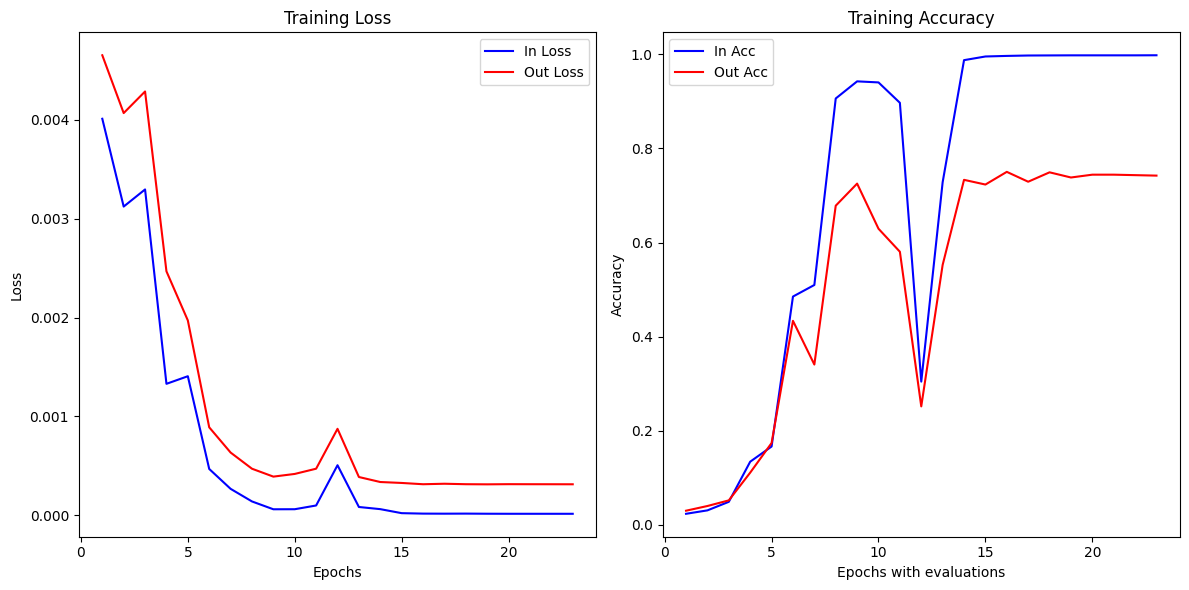

In [ ]:
plot_history(history)

In [ ]:
accuracy, average_loss = test_model(model, test_loader)

print(f'\nTest Accuracy: {accuracy * 100:.2f}%')
print(f'Average Test Loss: {average_loss:.4f}')

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Test Accuracy: 25.00%
Average Test Loss: 0.0085


Adjusting learning rate of group 0 to 1.0000e-02.
Starting training with decoder...


0it [00:00, ?it/s]


Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 1/20 [00:06<01:58,  6.25s/it]

Epoch 1, In-sample Loss: 0.0225, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0225, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 2/20 [00:13<01:59,  6.66s/it]

Epoch 2, In-sample Loss: 0.0452, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 0.0452, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 15%|█▌        | 3/20 [00:18<01:42,  6.04s/it]

Epoch 3, In-sample Loss: 0.0160, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0160, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 20%|██        | 4/20 [00:23<01:30,  5.67s/it]

Epoch 4, In-sample Loss: 0.0090, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.0090, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 25%|██▌       | 5/20 [00:28<01:23,  5.56s/it]

Epoch 5, In-sample Loss: 0.0097, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0097, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 30%|███       | 6/20 [00:33<01:10,  5.05s/it]

Epoch 6, In-sample Loss: 0.0073, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 0.0073, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 35%|███▌      | 7/20 [00:37<01:02,  4.78s/it]

Epoch 7, In-sample Loss: 0.0055, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.0055, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 40%|████      | 8/20 [00:43<01:02,  5.23s/it]

Epoch 8, In-sample Loss: 0.0053, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0053, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 45%|████▌     | 9/20 [00:47<00:54,  4.91s/it]

Epoch 9, In-sample Loss: 0.0053, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0053, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 45%|████▌     | 9/20 [00:49<01:00,  5.53s/it]


KeyboardInterrupt: ignored

In [ ]:
model = load_model('/content/gdrive/MyDrive/license_plate/models/best_model_1130.pth')
model1, history = train_full_model(model, train_danish_loader, val_danish_loader)
accuracyTrain, averageTrain_loss = test_model(model1, train_danish_loader)
accuracy, average_loss = test_model(model1, val_danish_loader)

print(f'\nTrain Accuracy: {accuracyTrain * 100:.2f}%')
print(f'Average train Loss: {averageTrain_loss:.4f}')

print(f'\nTest Accuracy: {accuracy * 100:.2f}%')
print(f'Average Test Loss: {average_loss:.4f}')

### Experiment: Tranfer learning to danish licence plates

In [ ]:
model = load_model('/content/gdrive/MyDrive/license_plate/models/best_model_1130.pth')
model1, history = train_full_model(model, train_danish_loader, val_danish_loader)
accuracyTrain, averageTrain_loss = test_model(model1, train_danish_loader)
accuracy, average_loss = test_model(model1, val_danish_loader)

print(f'\nTrain Accuracy: {accuracyTrain * 100:.2f}%')
print(f'Average train Loss: {averageTrain_loss:.4f}')

print(f'\nTest Accuracy: {accuracy * 100:.2f}%')
print(f'Average Test Loss: {average_loss:.4f}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Adjusting learning rate of group 0 to 1.0000e-02.
Starting training with decoder...


  0%|          | 0/10 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


 10%|█         | 1/10 [00:05<00:53,  5.90s/it]

Epoch 1, In-sample Loss: 0.2536, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.2536, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-03.


 20%|██        | 2/10 [00:10<00:39,  4.90s/it]

Epoch 2, In-sample Loss: 0.0467, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 0.0467, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-03.


 30%|███       | 3/10 [00:16<00:39,  5.67s/it]

Epoch 3, In-sample Loss: 0.0264, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0264, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-04.


 40%|████      | 4/10 [00:21<00:31,  5.29s/it]

Epoch 4, In-sample Loss: 0.0230, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.0230, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 3.1250e-04.


 50%|█████     | 5/10 [00:25<00:24,  4.87s/it]

Epoch 5, In-sample Loss: 0.0226, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0226, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.5625e-04.


 60%|██████    | 6/10 [00:30<00:20,  5.03s/it]

Epoch 6, In-sample Loss: 0.0223, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 0.0223, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 7.8125e-05.


 70%|███████   | 7/10 [00:36<00:16,  5.35s/it]

Epoch 7, In-sample Loss: 0.0218, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.0218, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 3.9063e-05.


 80%|████████  | 8/10 [00:41<00:09,  4.98s/it]

Epoch 8, In-sample Loss: 0.0213, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0213, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.9531e-05.


 90%|█████████ | 9/10 [00:45<00:04,  4.74s/it]

Epoch 9, In-sample Loss: 0.0208, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0208, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 9.7656e-06.


100%|██████████| 10/10 [00:52<00:00,  5.23s/it]


Epoch 10, In-sample Loss: 0.0206, In-sample Accuracy: 0.0000
Epoch 10, Out-sample Loss: 0.0206, Out-sample Accuracy: 0.0000
Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  1%|          | 1/100 [00:04<07:34,  4.59s/it]

Epoch 1, In-sample Loss: 0.0309, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0309, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  2%|▏         | 2/100 [00:08<07:13,  4.43s/it]

Epoch 2, In-sample Loss: 0.0298, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 0.0298, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  3%|▎         | 3/100 [00:15<08:37,  5.34s/it]

Epoch 3, In-sample Loss: 0.1125, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.1125, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  4%|▍         | 4/100 [00:20<08:22,  5.23s/it]

Epoch 4, In-sample Loss: 0.0563, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.0563, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 5/100 [00:24<07:38,  4.83s/it]

Epoch 5, In-sample Loss: 0.0464, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0464, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  6%|▌         | 6/100 [00:29<07:37,  4.86s/it]

Epoch 6, In-sample Loss: 0.0669, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 0.0669, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  7%|▋         | 7/100 [00:35<08:15,  5.33s/it]

Epoch 7, In-sample Loss: 0.0797, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.0797, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  8%|▊         | 8/100 [00:40<07:54,  5.16s/it]

Epoch 8, In-sample Loss: 0.0290, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0290, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


  9%|▉         | 9/100 [00:44<07:28,  4.93s/it]

Epoch 9, In-sample Loss: 0.0259, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0259, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 10/100 [00:52<08:23,  5.59s/it]

Epoch 10, In-sample Loss: 0.0222, In-sample Accuracy: 0.0000
Epoch 10, Out-sample Loss: 0.0222, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 11%|█         | 11/100 [00:56<07:39,  5.16s/it]

Epoch 11, In-sample Loss: 0.0224, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 0.0224, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 12%|█▏        | 12/100 [01:00<07:05,  4.83s/it]

Epoch 12, In-sample Loss: 0.0157, In-sample Accuracy: 0.0000
Epoch 12, Out-sample Loss: 0.0157, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 13%|█▎        | 13/100 [01:06<07:30,  5.17s/it]

Epoch 13, In-sample Loss: 0.0094, In-sample Accuracy: 0.0000
Epoch 13, Out-sample Loss: 0.0094, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 14%|█▍        | 14/100 [01:11<07:24,  5.17s/it]

Epoch 14, In-sample Loss: 0.0110, In-sample Accuracy: 0.0000
Epoch 14, Out-sample Loss: 0.0110, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 15%|█▌        | 15/100 [01:15<06:57,  4.91s/it]

Epoch 15, In-sample Loss: 0.0073, In-sample Accuracy: 0.0000
Epoch 15, Out-sample Loss: 0.0073, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 16%|█▌        | 16/100 [01:22<07:36,  5.43s/it]

Epoch 16, In-sample Loss: 0.0055, In-sample Accuracy: 0.0000
Epoch 16, Out-sample Loss: 0.0055, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 17%|█▋        | 17/100 [01:28<07:49,  5.66s/it]

Epoch 17, In-sample Loss: 0.0092, In-sample Accuracy: 0.0000
Epoch 17, Out-sample Loss: 0.0092, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 18%|█▊        | 18/100 [01:32<07:05,  5.19s/it]

Epoch 18, In-sample Loss: 0.0026, In-sample Accuracy: 0.0000
Epoch 18, Out-sample Loss: 0.0026, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.0000e-03.


 19%|█▉        | 19/100 [01:37<06:48,  5.05s/it]

Epoch 19, In-sample Loss: 0.0074, In-sample Accuracy: 0.0000
Epoch 19, Out-sample Loss: 0.0074, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 20%|██        | 20/100 [01:43<07:19,  5.49s/it]

Epoch 20, In-sample Loss: 0.0023, In-sample Accuracy: 0.0000
Epoch 20, Out-sample Loss: 0.0023, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 21%|██        | 21/100 [01:48<06:44,  5.12s/it]

Epoch 21, In-sample Loss: 0.0041, In-sample Accuracy: 0.0000
Epoch 21, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 22%|██▏       | 22/100 [01:52<06:17,  4.84s/it]

Epoch 22, In-sample Loss: 0.0022, In-sample Accuracy: 0.0000
Epoch 22, Out-sample Loss: 0.0022, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 23%|██▎       | 23/100 [01:59<07:00,  5.47s/it]

Epoch 23, In-sample Loss: 0.0028, In-sample Accuracy: 0.0000
Epoch 23, Out-sample Loss: 0.0028, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 24%|██▍       | 24/100 [02:03<06:32,  5.16s/it]

Epoch 24, In-sample Loss: 0.0018, In-sample Accuracy: 0.0000
Epoch 24, Out-sample Loss: 0.0018, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 25%|██▌       | 25/100 [02:07<06:05,  4.87s/it]

Epoch 25, In-sample Loss: 0.0016, In-sample Accuracy: 0.0000
Epoch 25, Out-sample Loss: 0.0016, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 26%|██▌       | 26/100 [02:13<06:21,  5.16s/it]

Epoch 26, In-sample Loss: 0.0015, In-sample Accuracy: 0.0000
Epoch 26, Out-sample Loss: 0.0015, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 27%|██▋       | 27/100 [02:19<06:21,  5.22s/it]

Epoch 27, In-sample Loss: 0.0015, In-sample Accuracy: 0.0000
Epoch 27, Out-sample Loss: 0.0015, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 28%|██▊       | 28/100 [02:23<05:55,  4.94s/it]

Epoch 28, In-sample Loss: 0.0015, In-sample Accuracy: 0.0000
Epoch 28, Out-sample Loss: 0.0015, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 29%|██▉       | 29/100 [02:28<05:45,  4.87s/it]

Epoch 29, In-sample Loss: 0.0012, In-sample Accuracy: 0.0000
Epoch 29, Out-sample Loss: 0.0012, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 30%|███       | 30/100 [02:34<06:17,  5.39s/it]

Epoch 30, In-sample Loss: 0.0011, In-sample Accuracy: 0.0000
Epoch 30, Out-sample Loss: 0.0011, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 31%|███       | 31/100 [02:38<05:44,  5.00s/it]

Epoch 31, In-sample Loss: 0.0012, In-sample Accuracy: 0.0000
Epoch 31, Out-sample Loss: 0.0012, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 32%|███▏      | 32/100 [02:42<05:23,  4.76s/it]

Epoch 32, In-sample Loss: 0.0012, In-sample Accuracy: 0.0000
Epoch 32, Out-sample Loss: 0.0012, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 33%|███▎      | 33/100 [02:49<06:01,  5.39s/it]

Epoch 33, In-sample Loss: 0.0011, In-sample Accuracy: 0.0000
Epoch 33, Out-sample Loss: 0.0011, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 34%|███▍      | 34/100 [02:54<05:36,  5.10s/it]

Epoch 34, In-sample Loss: 0.0012, In-sample Accuracy: 0.0000
Epoch 34, Out-sample Loss: 0.0012, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 35%|███▌      | 35/100 [02:58<05:13,  4.82s/it]

Epoch 35, In-sample Loss: 0.0011, In-sample Accuracy: 0.0000
Epoch 35, Out-sample Loss: 0.0011, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 36%|███▌      | 36/100 [03:04<05:23,  5.06s/it]

Epoch 36, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 36, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 37%|███▋      | 37/100 [03:10<05:40,  5.41s/it]

Epoch 37, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 37, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 38%|███▊      | 38/100 [03:14<05:09,  5.00s/it]

Epoch 38, In-sample Loss: 0.0010, In-sample Accuracy: 0.0000
Epoch 38, Out-sample Loss: 0.0010, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 5.0000e-04.


 39%|███▉      | 39/100 [03:18<04:51,  4.78s/it]

Epoch 39, In-sample Loss: 0.0015, In-sample Accuracy: 0.0000
Epoch 39, Out-sample Loss: 0.0015, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 40%|████      | 40/100 [03:25<05:28,  5.47s/it]

Epoch 40, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 40, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 41%|████      | 41/100 [03:29<05:00,  5.09s/it]

Epoch 41, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 41, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 42%|████▏     | 42/100 [03:34<04:40,  4.84s/it]

Epoch 42, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 42, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 43%|████▎     | 43/100 [03:40<05:04,  5.34s/it]

Epoch 43, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 43, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 44%|████▍     | 44/100 [03:45<04:47,  5.14s/it]

Epoch 44, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 44, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 45%|████▌     | 45/100 [03:49<04:26,  4.84s/it]

Epoch 45, In-sample Loss: 0.0011, In-sample Accuracy: 0.0000
Epoch 45, Out-sample Loss: 0.0011, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 46%|████▌     | 46/100 [03:54<04:29,  4.98s/it]

Epoch 46, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 46, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 47%|████▋     | 47/100 [04:00<04:44,  5.36s/it]

Epoch 47, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 47, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 48%|████▊     | 48/100 [04:05<04:18,  4.97s/it]

Epoch 48, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 48, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 49%|████▉     | 49/100 [04:09<03:58,  4.69s/it]

Epoch 49, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 49, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 50%|█████     | 50/100 [04:15<04:22,  5.26s/it]

Epoch 50, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 50, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 51%|█████     | 51/100 [04:19<03:58,  4.87s/it]

Epoch 51, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 51, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 52%|█████▏    | 52/100 [04:23<03:40,  4.60s/it]

Epoch 52, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 52, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 53%|█████▎    | 53/100 [04:28<03:44,  4.77s/it]

Epoch 53, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 53, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 54%|█████▍    | 54/100 [04:34<03:48,  4.97s/it]

Epoch 54, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 54, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 55%|█████▌    | 55/100 [04:38<03:30,  4.67s/it]

Epoch 55, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 55, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 56%|█████▌    | 56/100 [04:42<03:16,  4.47s/it]

Epoch 56, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 56, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 57%|█████▋    | 57/100 [04:48<03:41,  5.15s/it]

Epoch 57, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 57, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 58%|█████▊    | 58/100 [04:53<03:23,  4.84s/it]

Epoch 58, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 58, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 2.5000e-04.


 59%|█████▉    | 59/100 [04:57<03:07,  4.59s/it]

Epoch 59, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 59, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 60%|██████    | 60/100 [05:02<03:13,  4.83s/it]

Epoch 60, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 60, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 61%|██████    | 61/100 [05:07<03:11,  4.91s/it]

Epoch 61, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 61, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 62%|██████▏   | 62/100 [05:11<02:53,  4.58s/it]

Epoch 62, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 62, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 63%|██████▎   | 63/100 [05:15<02:41,  4.36s/it]

Epoch 63, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 63, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 64%|██████▍   | 64/100 [05:21<03:01,  5.04s/it]

Epoch 64, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 64, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 65%|██████▌   | 65/100 [05:25<02:44,  4.70s/it]

Epoch 65, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 65, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 66%|██████▌   | 66/100 [05:29<02:32,  4.47s/it]

Epoch 66, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 66, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 67%|██████▋   | 67/100 [05:34<02:35,  4.71s/it]

Epoch 67, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 67, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 68%|██████▊   | 68/100 [05:40<02:35,  4.85s/it]

Epoch 68, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 68, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 69%|██████▉   | 69/100 [05:44<02:21,  4.57s/it]

Epoch 69, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 69, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 70%|███████   | 70/100 [05:47<02:11,  4.38s/it]

Epoch 70, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 70, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 71%|███████   | 71/100 [05:54<02:26,  5.05s/it]

Epoch 71, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 71, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 72%|███████▏  | 72/100 [05:58<02:11,  4.71s/it]

Epoch 72, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 72, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 73%|███████▎  | 73/100 [06:02<02:00,  4.46s/it]

Epoch 73, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 73, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 74%|███████▍  | 74/100 [06:07<02:02,  4.70s/it]

Epoch 74, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 74, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 75%|███████▌  | 75/100 [06:12<02:01,  4.85s/it]

Epoch 75, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 75, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 76%|███████▌  | 76/100 [06:16<01:49,  4.55s/it]

Epoch 76, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 76, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 77%|███████▋  | 77/100 [06:20<01:39,  4.34s/it]

Epoch 77, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 77, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 78%|███████▊  | 78/100 [06:26<01:48,  4.93s/it]

Epoch 78, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 78, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 1.2500e-04.


 79%|███████▉  | 79/100 [06:30<01:38,  4.70s/it]

Epoch 79, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 79, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 80%|████████  | 80/100 [06:34<01:28,  4.44s/it]

Epoch 80, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 80, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 81%|████████  | 81/100 [06:39<01:26,  4.55s/it]

Epoch 81, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 81, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 82%|████████▏ | 82/100 [06:45<01:27,  4.86s/it]

Epoch 82, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 82, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 83%|████████▎ | 83/100 [06:49<01:18,  4.61s/it]

Epoch 83, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 83, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 84%|████████▍ | 84/100 [06:53<01:10,  4.40s/it]

Epoch 84, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 84, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 85%|████████▌ | 85/100 [06:59<01:13,  4.92s/it]

Epoch 85, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 85, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 86%|████████▌ | 86/100 [07:03<01:06,  4.75s/it]

Epoch 86, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 86, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 87%|████████▋ | 87/100 [07:07<00:58,  4.49s/it]

Epoch 87, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 87, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 88%|████████▊ | 88/100 [07:12<00:54,  4.52s/it]

Epoch 88, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 88, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 89%|████████▉ | 89/100 [07:17<00:54,  4.92s/it]

Epoch 89, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 89, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 90%|█████████ | 90/100 [07:21<00:46,  4.60s/it]

Epoch 90, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 90, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 91%|█████████ | 91/100 [07:25<00:39,  4.39s/it]

Epoch 91, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 91, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 92%|█████████▏| 92/100 [07:31<00:39,  4.88s/it]

Epoch 92, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 92, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 93%|█████████▎| 93/100 [07:36<00:33,  4.76s/it]

Epoch 93, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 93, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 94%|█████████▍| 94/100 [07:40<00:26,  4.49s/it]

Epoch 94, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 94, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 95%|█████████▌| 95/100 [07:44<00:22,  4.51s/it]

Epoch 95, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 95, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 96%|█████████▌| 96/100 [07:50<00:20,  5.04s/it]

Epoch 96, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 96, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 97%|█████████▋| 97/100 [07:54<00:14,  4.69s/it]

Epoch 97, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 97, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 98%|█████████▊| 98/100 [07:58<00:08,  4.47s/it]

Epoch 98, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 98, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 6.2500e-05.


 99%|█████████▉| 99/100 [08:04<00:04,  4.80s/it]

Epoch 99, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 99, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000
Adjusting learning rate of group 0 to 3.1250e-05.


100%|██████████| 100/100 [08:09<00:00,  4.89s/it]


Epoch 100, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 100, Out-sample Loss: 0.0007, Out-sample Accuracy: 0.0000


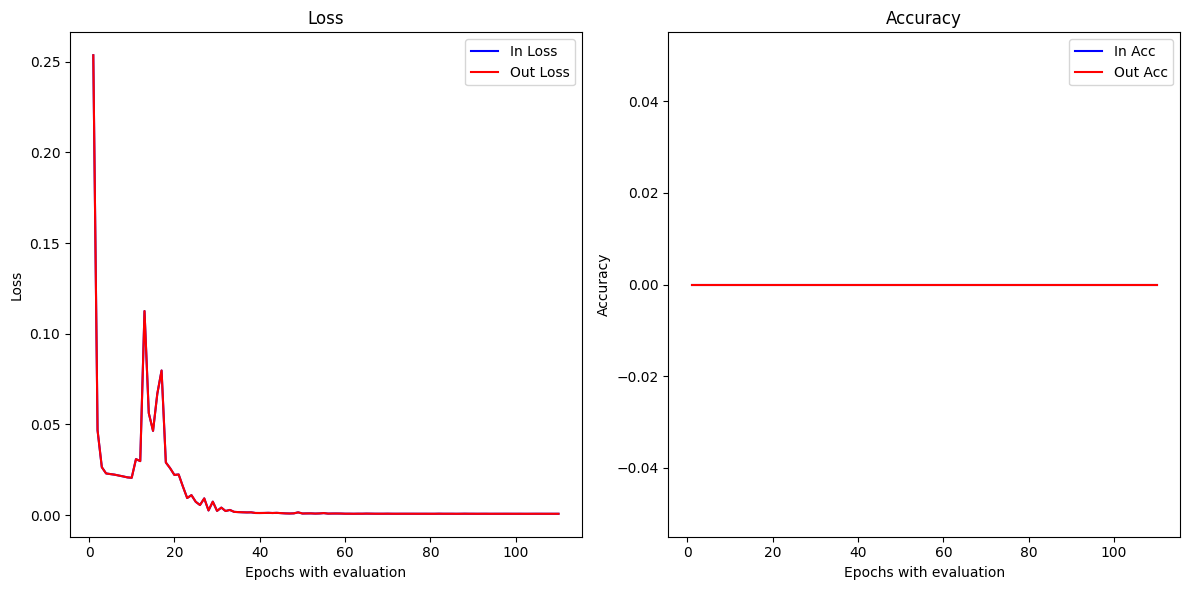

In [58]:
model = get_new_model()
trained_model, history = train_full_model(model, train_danish_loader, val_danish_loader)
plot_history(history)

### Experiment: Normalized labels & learning rate

In [ ]:

lr_to_test = [(1e-4, 1e-2),(1e-4, 1e-1),(1e-3, 1e-2)]

in_loss_standard_hist = []
out_loss_standard_hist = []

in_acc_standard_hist = []
out_acc_standard_hist = []


for index, (lr_base, lr_max) in enumerate(lr_to_test):
  model = get_new_model()
  cyclic_lr = {'base_lr': lr_base, 'max_lr': lr_max}
  _, history = train_full_model(model, cyclic_lr)
  in_loss_standard_hist.append(history['in_loss'])
  out_loss_standard_hist.append(history['out_loss'])
  in_acc_standard_hist.append(history['in_acc'])
  out_acc_standard_hist.append(history['out_acc'])



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting training with decoder...


 20%|██        | 1/5 [00:34<02:18, 34.51s/it]

Epoch 1, In-sample Loss: 10951.6523, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 11534.5020, Out-sample Accuracy: 0.0000


 60%|██████    | 3/5 [01:18<00:51, 25.61s/it]

Epoch 3, In-sample Loss: 1011.0090, In-sample Accuracy: 0.0220
Epoch 3, Out-sample Loss: 1179.8236, Out-sample Accuracy: 0.0100


100%|██████████| 5/5 [02:03<00:00, 24.65s/it]


Epoch 5, In-sample Loss: 380.9440, In-sample Accuracy: 0.1620
Epoch 5, Out-sample Loss: 454.9691, Out-sample Accuracy: 0.1100
Starting full model training with cyclic LR ...


  5%|▌         | 1/20 [00:31<09:57, 31.46s/it]

Epoch 1, In-sample Loss: 259.7366, In-sample Accuracy: 0.2130
Epoch 1, Out-sample Loss: 310.7838, Out-sample Accuracy: 0.1550


 15%|█▌        | 3/20 [01:13<06:57, 24.55s/it]

Epoch 3, In-sample Loss: 4834.0034, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 4660.0581, Out-sample Accuracy: 0.0000


 25%|██▌       | 5/20 [01:59<06:08, 24.59s/it]

Epoch 5, In-sample Loss: 18331.4308, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 16424.7334, Out-sample Accuracy: 0.0000


 35%|███▌      | 7/20 [02:42<05:04, 23.42s/it]

Epoch 7, In-sample Loss: 4616.2402, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 4169.9203, Out-sample Accuracy: 0.0000


 45%|████▌     | 9/20 [03:27<04:22, 23.86s/it]

Epoch 9, In-sample Loss: 575.1099, In-sample Accuracy: 0.0010
Epoch 9, Out-sample Loss: 543.9368, Out-sample Accuracy: 0.0250


 55%|█████▌    | 11/20 [04:09<03:25, 22.88s/it]

Epoch 11, In-sample Loss: 186.1844, In-sample Accuracy: 0.0250
Epoch 11, Out-sample Loss: 191.7141, Out-sample Accuracy: 0.1000


 65%|██████▌   | 13/20 [04:54<02:43, 23.37s/it]

Epoch 13, In-sample Loss: 120.6094, In-sample Accuracy: 0.0520
Epoch 13, Out-sample Loss: 129.1261, Out-sample Accuracy: 0.1900


 75%|███████▌  | 15/20 [05:35<01:53, 22.68s/it]

Epoch 15, In-sample Loss: 55.9487, In-sample Accuracy: 0.7790
Epoch 15, Out-sample Loss: 70.8623, Out-sample Accuracy: 0.7850


 85%|████████▌ | 17/20 [06:20<01:09, 23.26s/it]

Epoch 17, In-sample Loss: 188.4750, In-sample Accuracy: 0.0180
Epoch 17, Out-sample Loss: 201.1997, Out-sample Accuracy: 0.1300


 95%|█████████▌| 19/20 [07:02<00:22, 22.82s/it]

Epoch 19, In-sample Loss: 95.9573, In-sample Accuracy: 0.0240
Epoch 19, Out-sample Loss: 110.4232, Out-sample Accuracy: 0.1850


100%|██████████| 20/20 [07:16<00:00, 21.83s/it]


Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


  5%|▌         | 1/20 [00:30<09:42, 30.63s/it]

Epoch 1, In-sample Loss: 63.0895, In-sample Accuracy: 0.1990
Epoch 1, Out-sample Loss: 74.1815, Out-sample Accuracy: 0.4500


 10%|█         | 2/20 [00:44<06:15, 20.87s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 15%|█▌        | 3/20 [01:12<06:46, 23.89s/it]

Epoch 3, In-sample Loss: 26.6208, In-sample Accuracy: 0.8470
Epoch 3, Out-sample Loss: 41.8567, Out-sample Accuracy: 0.8350


 20%|██        | 4/20 [01:25<05:17, 19.82s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 25%|██▌       | 5/20 [01:56<05:55, 23.71s/it]

Epoch 5, In-sample Loss: 10.2471, In-sample Accuracy: 0.9680
Epoch 5, Out-sample Loss: 26.1979, Out-sample Accuracy: 0.9000


 30%|███       | 6/20 [02:10<04:47, 20.53s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 35%|███▌      | 7/20 [02:39<05:02, 23.25s/it]

Epoch 7, In-sample Loss: 7.6847, In-sample Accuracy: 0.9960
Epoch 7, Out-sample Loss: 24.7996, Out-sample Accuracy: 0.8950


 40%|████      | 8/20 [02:52<04:00, 20.05s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 45%|████▌     | 9/20 [03:23<04:17, 23.42s/it]

Epoch 9, In-sample Loss: 7.5718, In-sample Accuracy: 0.9960
Epoch 9, Out-sample Loss: 24.9021, Out-sample Accuracy: 0.8950


 50%|█████     | 10/20 [03:37<03:25, 20.56s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 55%|█████▌    | 11/20 [04:05<03:25, 22.78s/it]

Epoch 11, In-sample Loss: 2.7471, In-sample Accuracy: 0.9980
Epoch 11, Out-sample Loss: 20.2822, Out-sample Accuracy: 0.9100


 60%|██████    | 12/20 [04:18<02:37, 19.73s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 65%|██████▌   | 13/20 [04:48<02:40, 22.96s/it]

Epoch 13, In-sample Loss: 1.2545, In-sample Accuracy: 0.9990
Epoch 13, Out-sample Loss: 19.3071, Out-sample Accuracy: 0.9150


 70%|███████   | 14/20 [05:02<02:01, 20.27s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 75%|███████▌  | 15/20 [05:30<01:52, 22.42s/it]

Epoch 15, In-sample Loss: 2.1864, In-sample Accuracy: 0.9990
Epoch 15, Out-sample Loss: 20.2710, Out-sample Accuracy: 0.9100


 80%|████████  | 16/20 [05:43<01:18, 19.60s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 85%|████████▌ | 17/20 [06:13<01:08, 22.80s/it]

Epoch 17, In-sample Loss: 1.3742, In-sample Accuracy: 0.9990
Epoch 17, Out-sample Loss: 19.8351, Out-sample Accuracy: 0.8950


 90%|█████████ | 18/20 [06:27<00:40, 20.15s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 95%|█████████▌| 19/20 [06:54<00:22, 22.14s/it]

Epoch 19, In-sample Loss: 0.8018, In-sample Accuracy: 0.9990
Epoch 19, Out-sample Loss: 19.2271, Out-sample Accuracy: 0.9100


100%|██████████| 20/20 [07:08<00:00, 21.43s/it]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Adjusting learning rate of group 0 to 1.0000e-04.
Starting training with decoder...


 20%|██        | 1/5 [00:30<02:02, 30.54s/it]

Epoch 1, In-sample Loss: 10910.3143, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 11495.9613, Out-sample Accuracy: 0.0000


 60%|██████    | 3/5 [01:11<00:47, 23.51s/it]

Epoch 3, In-sample Loss: 1066.5817, In-sample Accuracy: 0.0160
Epoch 3, Out-sample Loss: 1231.1513, Out-sample Accuracy: 0.0200


100%|██████████| 5/5 [01:55<00:00, 23.08s/it]


Epoch 5, In-sample Loss: 402.9236, In-sample Accuracy: 0.1440
Epoch 5, Out-sample Loss: 482.0970, Out-sample Accuracy: 0.1250
Starting full model training with cyclic LR ...


  5%|▌         | 1/20 [00:29<09:13, 29.11s/it]

Epoch 1, In-sample Loss: 248.7718, In-sample Accuracy: 0.2180
Epoch 1, Out-sample Loss: 307.6672, Out-sample Accuracy: 0.2000


 15%|█▌        | 3/20 [01:12<06:56, 24.51s/it]

Epoch 3, In-sample Loss: 122237664786041520128.0000, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 120250138661396414464.0000, Out-sample Accuracy: 0.0000


 25%|██▌       | 5/20 [01:55<05:53, 23.57s/it]

Epoch 5, In-sample Loss: 2377741370392.5762, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 2398367913082.8799, Out-sample Accuracy: 0.0000


 35%|███▌      | 7/20 [02:37<05:00, 23.11s/it]

Epoch 7, In-sample Loss: 118981224.4480, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 115256957.7600, Out-sample Accuracy: 0.0000


 45%|████▌     | 9/20 [03:20<04:11, 22.84s/it]

Epoch 9, In-sample Loss: 206160.0649, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 228080.9237, Out-sample Accuracy: 0.0000


 55%|█████▌    | 11/20 [04:03<03:26, 22.96s/it]

Epoch 11, In-sample Loss: 17555.6691, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 21567.9075, Out-sample Accuracy: 0.0000


 65%|██████▌   | 13/20 [04:46<02:39, 22.79s/it]

Epoch 13, In-sample Loss: 1190.5792, In-sample Accuracy: 0.0020
Epoch 13, Out-sample Loss: 1167.3136, Out-sample Accuracy: 0.0100


 75%|███████▌  | 15/20 [05:28<01:54, 22.92s/it]

Epoch 15, In-sample Loss: 630.5513, In-sample Accuracy: 0.0210
Epoch 15, Out-sample Loss: 611.5744, Out-sample Accuracy: 0.0750


 85%|████████▌ | 17/20 [06:12<01:08, 22.96s/it]

Epoch 17, In-sample Loss: 1035.9115, In-sample Accuracy: 0.0180
Epoch 17, Out-sample Loss: 1114.8764, Out-sample Accuracy: 0.0500


 95%|█████████▌| 19/20 [06:55<00:22, 23.00s/it]

Epoch 19, In-sample Loss: 187.3504, In-sample Accuracy: 0.1500
Epoch 19, Out-sample Loss: 233.7164, Out-sample Accuracy: 0.1400


100%|██████████| 20/20 [07:09<00:00, 21.49s/it]


Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


  5%|▌         | 1/20 [00:28<09:02, 28.55s/it]

Epoch 1, In-sample Loss: 143.8421, In-sample Accuracy: 0.0910
Epoch 1, Out-sample Loss: 188.8654, Out-sample Accuracy: 0.0900


 10%|█         | 2/20 [00:40<05:41, 18.98s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 15%|█▌        | 3/20 [01:11<06:49, 24.10s/it]

Epoch 3, In-sample Loss: 73.7236, In-sample Accuracy: 0.4220
Epoch 3, Out-sample Loss: 108.9529, Out-sample Accuracy: 0.3900


 20%|██        | 4/20 [01:25<05:23, 20.23s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 25%|██▌       | 5/20 [01:53<05:45, 23.06s/it]

Epoch 5, In-sample Loss: 50.7146, In-sample Accuracy: 0.6750
Epoch 5, Out-sample Loss: 82.5429, Out-sample Accuracy: 0.5800


 30%|███       | 6/20 [02:06<04:33, 19.55s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 35%|███▌      | 7/20 [02:36<04:58, 22.97s/it]

Epoch 7, In-sample Loss: 39.3151, In-sample Accuracy: 0.7880
Epoch 7, Out-sample Loss: 67.8507, Out-sample Accuracy: 0.6650


 40%|████      | 8/20 [02:50<04:02, 20.17s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 45%|████▌     | 9/20 [03:18<04:09, 22.66s/it]

Epoch 9, In-sample Loss: 32.2653, In-sample Accuracy: 0.8900
Epoch 9, Out-sample Loss: 59.4741, Out-sample Accuracy: 0.7600


 50%|█████     | 10/20 [03:31<03:16, 19.60s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 55%|█████▌    | 11/20 [04:01<03:25, 22.85s/it]

Epoch 11, In-sample Loss: 24.1515, In-sample Accuracy: 0.9380
Epoch 11, Out-sample Loss: 48.7279, Out-sample Accuracy: 0.7950


 60%|██████    | 12/20 [04:15<02:41, 20.15s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 65%|██████▌   | 13/20 [04:43<02:37, 22.50s/it]

Epoch 13, In-sample Loss: 17.5160, In-sample Accuracy: 0.9570
Epoch 13, Out-sample Loss: 40.4261, Out-sample Accuracy: 0.8200


 70%|███████   | 14/20 [04:56<01:57, 19.59s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 75%|███████▌  | 15/20 [05:26<01:53, 22.77s/it]

Epoch 15, In-sample Loss: 15.4956, In-sample Accuracy: 0.9620
Epoch 15, Out-sample Loss: 37.9953, Out-sample Accuracy: 0.8300


 80%|████████  | 16/20 [05:40<01:20, 20.08s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 85%|████████▌ | 17/20 [06:07<01:06, 22.29s/it]

Epoch 17, In-sample Loss: 12.9107, In-sample Accuracy: 0.9700
Epoch 17, Out-sample Loss: 34.4017, Out-sample Accuracy: 0.8400


 90%|█████████ | 18/20 [06:21<00:39, 19.63s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 95%|█████████▌| 19/20 [06:51<00:22, 22.80s/it]

Epoch 19, In-sample Loss: 11.0596, In-sample Accuracy: 0.9740
Epoch 19, Out-sample Loss: 31.9073, Out-sample Accuracy: 0.8500


100%|██████████| 20/20 [07:05<00:00, 21.28s/it]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Adjusting learning rate of group 0 to 1.0000e-04.
Starting training with decoder...


 20%|██        | 1/5 [00:26<01:47, 26.91s/it]

Epoch 1, In-sample Loss: 10835.8930, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 11418.8894, Out-sample Accuracy: 0.0000


 60%|██████    | 3/5 [01:09<00:47, 23.79s/it]

Epoch 3, In-sample Loss: 954.5178, In-sample Accuracy: 0.0260
Epoch 3, Out-sample Loss: 1118.6781, Out-sample Accuracy: 0.0050


100%|██████████| 5/5 [01:50<00:00, 22.04s/it]


Epoch 5, In-sample Loss: 379.9238, In-sample Accuracy: 0.1550
Epoch 5, Out-sample Loss: 453.9418, Out-sample Accuracy: 0.1050
Starting full model training with cyclic LR ...


  5%|▌         | 1/20 [00:30<09:43, 30.69s/it]

Epoch 1, In-sample Loss: 386.9582, In-sample Accuracy: 0.1550
Epoch 1, Out-sample Loss: 438.0007, Out-sample Accuracy: 0.1350


 15%|█▌        | 3/20 [01:12<06:48, 24.01s/it]

Epoch 3, In-sample Loss: 11690.5303, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 10179.3100, Out-sample Accuracy: 0.0000


 25%|██▌       | 5/20 [01:55<05:52, 23.47s/it]

Epoch 5, In-sample Loss: 9977.4468, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 10134.0364, Out-sample Accuracy: 0.0000


 35%|███▌      | 7/20 [02:38<04:58, 23.00s/it]

Epoch 7, In-sample Loss: 1375.4979, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 1382.7254, Out-sample Accuracy: 0.0000


 45%|████▌     | 9/20 [03:21<04:13, 23.02s/it]

Epoch 9, In-sample Loss: 507.6267, In-sample Accuracy: 0.1330
Epoch 9, Out-sample Loss: 494.2974, Out-sample Accuracy: 0.1550


 55%|█████▌    | 11/20 [04:02<03:21, 22.37s/it]

Epoch 11, In-sample Loss: 271.5217, In-sample Accuracy: 0.3470
Epoch 11, Out-sample Loss: 262.2765, Out-sample Accuracy: 0.3900


 65%|██████▌   | 13/20 [04:46<02:40, 22.89s/it]

Epoch 13, In-sample Loss: 193.0767, In-sample Accuracy: 0.2390
Epoch 13, Out-sample Loss: 197.4191, Out-sample Accuracy: 0.2900


 75%|███████▌  | 15/20 [05:27<01:51, 22.37s/it]

Epoch 15, In-sample Loss: 149.3961, In-sample Accuracy: 0.0140
Epoch 15, Out-sample Loss: 155.9843, Out-sample Accuracy: 0.1300


 85%|████████▌ | 17/20 [06:11<01:08, 22.78s/it]

Epoch 17, In-sample Loss: 228.1685, In-sample Accuracy: 0.0010
Epoch 17, Out-sample Loss: 227.0087, Out-sample Accuracy: 0.0500


 95%|█████████▌| 19/20 [06:51<00:22, 22.02s/it]

Epoch 19, In-sample Loss: 142.6289, In-sample Accuracy: 0.6410
Epoch 19, Out-sample Loss: 155.8914, Out-sample Accuracy: 0.7150


100%|██████████| 20/20 [07:05<00:00, 21.28s/it]


Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 1/20 [00:30<09:32, 30.14s/it]

Epoch 1, In-sample Loss: 431.0831, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 412.7740, Out-sample Accuracy: 0.0000


 10%|█         | 2/20 [00:43<06:02, 20.14s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 15%|█▌        | 3/20 [01:10<06:39, 23.52s/it]

Epoch 3, In-sample Loss: 259.4934, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 272.7210, Out-sample Accuracy: 0.0000


 20%|██        | 4/20 [01:25<05:18, 19.93s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 25%|██▌       | 5/20 [01:55<05:53, 23.58s/it]

Epoch 5, In-sample Loss: 168.0175, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 171.2971, Out-sample Accuracy: 0.0050


 30%|███       | 6/20 [02:08<04:38, 19.91s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 35%|███▌      | 7/20 [02:36<04:54, 22.67s/it]

Epoch 7, In-sample Loss: 35.4303, In-sample Accuracy: 0.9860
Epoch 7, Out-sample Loss: 50.1016, Out-sample Accuracy: 0.9150


 40%|████      | 8/20 [02:50<03:59, 19.92s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 45%|████▌     | 9/20 [03:20<04:13, 23.05s/it]

Epoch 9, In-sample Loss: 19.7636, In-sample Accuracy: 0.9940
Epoch 9, Out-sample Loss: 33.8803, Out-sample Accuracy: 0.9150


 50%|█████     | 10/20 [03:32<03:18, 19.81s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 55%|█████▌    | 11/20 [04:01<03:22, 22.46s/it]

Epoch 11, In-sample Loss: 64.3514, In-sample Accuracy: 0.4650
Epoch 11, Out-sample Loss: 78.6737, Out-sample Accuracy: 0.6600


 60%|██████    | 12/20 [04:15<02:38, 19.85s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 65%|██████▌   | 13/20 [04:45<02:40, 22.97s/it]

Epoch 13, In-sample Loss: 92.0813, In-sample Accuracy: 0.0460
Epoch 13, Out-sample Loss: 106.2475, Out-sample Accuracy: 0.3450


 70%|███████   | 14/20 [04:57<01:58, 19.71s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 75%|███████▌  | 15/20 [05:26<01:52, 22.52s/it]

Epoch 15, In-sample Loss: 33.1044, In-sample Accuracy: 0.3170
Epoch 15, Out-sample Loss: 45.0239, Out-sample Accuracy: 0.5450


 80%|████████  | 16/20 [05:40<01:19, 19.98s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 85%|████████▌ | 17/20 [06:10<01:08, 22.96s/it]

Epoch 17, In-sample Loss: 13.9143, In-sample Accuracy: 0.9960
Epoch 17, Out-sample Loss: 27.6864, Out-sample Accuracy: 0.8900


 90%|█████████ | 18/20 [06:22<00:39, 19.75s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 95%|█████████▌| 19/20 [06:51<00:22, 22.36s/it]

Epoch 19, In-sample Loss: 11.1121, In-sample Accuracy: 0.9970
Epoch 19, Out-sample Loss: 25.4943, Out-sample Accuracy: 0.9000


100%|██████████| 20/20 [07:05<00:00, 21.27s/it]

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
# Now with normalized labels

# Define new dataloaders:

# Training
train_dataset = LabelFpsDataLoader(TRAIN_PATH, (224, 224), normalize_labels=True)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)

# Validation
val_dataset = LabelFpsDataLoader(VAL_PATH, (224, 224), normalize_labels=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)

# Test
test_dataset = LabelFpsDataLoader(TEST_PATH, (224, 224), normalize_labels=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=2)



# Use subsets for faster iterations during development
if USE_SUBSET:
    # Training
    train_dataset = Subset(train_dataset, indices=range(SUBSET_INDICES))
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    # Validation
    val_dataset = Subset(val_dataset, indices=range(SUBSET_VAL_INDICES))
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)
    # Test
    test_dataset = Subset(test_dataset, indices=range(SUBSET_TEST_INDICES))
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=2)

in_loss_normalized_hist = []
out_loss_normalized_hist = []

in_acc_normalized_hist = []
out_acc_normalized_hist = []


for index, (lr_base, lr_max) in enumerate(lr_to_test):
  model = get_new_model()
  cyclic_lr = {'base_lr': lr_base, 'max_lr': lr_max}
  _, history = train_full_model(model, cyclic_lr)
  in_loss_normalized_hist.append(history['in_loss'])
  out_loss_normalized_hist.append(history['out_loss'])
  in_acc_normalized_hist.append(history['in_acc'])
  out_acc_normalized_hist.append(history['out_acc'])

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting training with decoder...


 20%|██        | 1/5 [00:28<01:54, 28.75s/it]

Epoch 1, In-sample Loss: 0.0094, In-sample Accuracy: 0.0620
Epoch 1, Out-sample Loss: 0.0094, Out-sample Accuracy: 0.1200


 60%|██████    | 3/5 [01:10<00:47, 23.77s/it]

Epoch 3, In-sample Loss: 0.0045, In-sample Accuracy: 0.1840
Epoch 3, Out-sample Loss: 0.0061, Out-sample Accuracy: 0.1400


100%|██████████| 5/5 [01:51<00:00, 22.23s/it]


Epoch 5, In-sample Loss: 0.0035, In-sample Accuracy: 0.2960
Epoch 5, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.3000
Starting full model training with cyclic LR ...


  5%|▌         | 1/20 [00:29<09:11, 29.01s/it]

Epoch 1, In-sample Loss: 0.0023, In-sample Accuracy: 0.3710
Epoch 1, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.2750


 15%|█▌        | 3/20 [01:12<06:54, 24.39s/it]

Epoch 3, In-sample Loss: 0.0739, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0586, Out-sample Accuracy: 0.0000


 25%|██▌       | 5/20 [01:53<05:43, 22.88s/it]

Epoch 5, In-sample Loss: 0.0891, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0840, Out-sample Accuracy: 0.0000


 35%|███▌      | 7/20 [02:37<05:01, 23.16s/it]

Epoch 7, In-sample Loss: 14.0381, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 11.4814, Out-sample Accuracy: 0.0000


 45%|████▌     | 9/20 [03:18<04:09, 22.69s/it]

Epoch 9, In-sample Loss: 10.4283, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 9.5754, Out-sample Accuracy: 0.0000


 55%|█████▌    | 11/20 [04:02<03:27, 23.02s/it]

Epoch 11, In-sample Loss: 62.9241, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 51.1275, Out-sample Accuracy: 0.0000


 65%|██████▌   | 13/20 [04:43<02:38, 22.67s/it]

Epoch 13, In-sample Loss: 0.1541, In-sample Accuracy: 0.0000
Epoch 13, Out-sample Loss: 0.1452, Out-sample Accuracy: 0.0000


 75%|███████▌  | 15/20 [05:27<01:54, 22.83s/it]

Epoch 15, In-sample Loss: 0.0317, In-sample Accuracy: 0.0000
Epoch 15, Out-sample Loss: 0.0313, Out-sample Accuracy: 0.0000


 85%|████████▌ | 17/20 [06:08<01:07, 22.66s/it]

Epoch 17, In-sample Loss: 0.0090, In-sample Accuracy: 0.0480
Epoch 17, Out-sample Loss: 0.0089, Out-sample Accuracy: 0.2100


 95%|█████████▌| 19/20 [06:52<00:22, 22.86s/it]

Epoch 19, In-sample Loss: 0.0072, In-sample Accuracy: 0.0290
Epoch 19, Out-sample Loss: 0.0073, Out-sample Accuracy: 0.1450


100%|██████████| 20/20 [07:04<00:00, 21.21s/it]


Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


  5%|▌         | 1/20 [00:31<09:51, 31.11s/it]

Epoch 1, In-sample Loss: 0.0028, In-sample Accuracy: 0.2620
Epoch 1, Out-sample Loss: 0.0030, Out-sample Accuracy: 0.5000


 10%|█         | 2/20 [00:45<06:25, 21.40s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 15%|█▌        | 3/20 [01:15<07:06, 25.09s/it]

Epoch 3, In-sample Loss: 0.0013, In-sample Accuracy: 0.7670
Epoch 3, Out-sample Loss: 0.0015, Out-sample Accuracy: 0.8100


 20%|██        | 4/20 [01:28<05:25, 20.35s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 25%|██▌       | 5/20 [01:55<05:43, 22.87s/it]

Epoch 5, In-sample Loss: 0.0006, In-sample Accuracy: 0.9350
Epoch 5, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.8800


 30%|███       | 6/20 [02:08<04:33, 19.51s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 35%|███▌      | 7/20 [02:37<04:54, 22.63s/it]

Epoch 7, In-sample Loss: 0.0003, In-sample Accuracy: 0.9860
Epoch 7, Out-sample Loss: 0.0006, Out-sample Accuracy: 0.9000


 40%|████      | 8/20 [02:51<03:56, 19.73s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 45%|████▌     | 9/20 [03:20<04:09, 22.72s/it]

Epoch 9, In-sample Loss: 0.0002, In-sample Accuracy: 0.9940
Epoch 9, Out-sample Loss: 0.0005, Out-sample Accuracy: 0.9150


 50%|█████     | 10/20 [03:32<03:15, 19.56s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 55%|█████▌    | 11/20 [04:00<03:17, 21.98s/it]

Epoch 11, In-sample Loss: 0.0001, In-sample Accuracy: 0.9990
Epoch 11, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.9200


 60%|██████    | 12/20 [04:14<02:35, 19.44s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 65%|██████▌   | 13/20 [04:43<02:36, 22.38s/it]

Epoch 13, In-sample Loss: 0.0001, In-sample Accuracy: 0.9980
Epoch 13, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.9100


 70%|███████   | 14/20 [04:56<01:58, 19.75s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 75%|███████▌  | 15/20 [05:25<01:52, 22.52s/it]

Epoch 15, In-sample Loss: 0.0000, In-sample Accuracy: 0.9980
Epoch 15, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.9050


 80%|████████  | 16/20 [05:38<01:18, 19.52s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 85%|████████▌ | 17/20 [06:05<01:05, 21.91s/it]

Epoch 17, In-sample Loss: 0.0001, In-sample Accuracy: 0.9990
Epoch 17, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.9100


 90%|█████████ | 18/20 [06:19<00:38, 19.39s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 95%|█████████▌| 19/20 [06:47<00:22, 22.16s/it]

Epoch 19, In-sample Loss: 0.0001, In-sample Accuracy: 0.9980
Epoch 19, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.9200


100%|██████████| 20/20 [07:01<00:00, 21.07s/it]

Adjusting learning rate of group 0 to 1.0000e-04.



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting training with decoder...


 20%|██        | 1/5 [00:27<01:51, 27.90s/it]

Epoch 1, In-sample Loss: 0.0118, In-sample Accuracy: 0.0080
Epoch 1, Out-sample Loss: 0.0133, Out-sample Accuracy: 0.0000


 60%|██████    | 3/5 [01:06<00:44, 22.49s/it]

Epoch 3, In-sample Loss: 0.0045, In-sample Accuracy: 0.1290
Epoch 3, Out-sample Loss: 0.0058, Out-sample Accuracy: 0.1450


100%|██████████| 5/5 [01:48<00:00, 21.80s/it]


Epoch 5, In-sample Loss: 0.0040, In-sample Accuracy: 0.1200
Epoch 5, Out-sample Loss: 0.0056, Out-sample Accuracy: 0.1200
Starting full model training with cyclic LR ...


  5%|▌         | 1/20 [00:28<09:06, 28.74s/it]

Epoch 1, In-sample Loss: 0.0024, In-sample Accuracy: 0.3180
Epoch 1, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.2700


 15%|█▌        | 3/20 [01:08<06:26, 22.74s/it]

Epoch 3, In-sample Loss: 21958797006854645631418368.0000, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 23038099658792143289319424.0000, Out-sample Accuracy: 0.0000


 25%|██▌       | 5/20 [01:50<05:38, 22.58s/it]

Epoch 5, In-sample Loss: 2813661173252.0962, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 3004683056578.5601, Out-sample Accuracy: 0.0000


 35%|███▌      | 7/20 [02:32<04:50, 22.37s/it]

Epoch 7, In-sample Loss: 30270.4876, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 34184.3842, Out-sample Accuracy: 0.0000


 45%|████▌     | 9/20 [03:11<03:59, 21.79s/it]

Epoch 9, In-sample Loss: 8.6162, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 8.8391, Out-sample Accuracy: 0.0000


 55%|█████▌    | 11/20 [03:53<03:19, 22.15s/it]

Epoch 11, In-sample Loss: 0.0788, In-sample Accuracy: 0.0110
Epoch 11, Out-sample Loss: 0.0803, Out-sample Accuracy: 0.0200


 65%|██████▌   | 13/20 [04:35<02:33, 21.99s/it]

Epoch 13, In-sample Loss: 0.0033, In-sample Accuracy: 0.3280
Epoch 13, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.3450


 75%|███████▌  | 15/20 [05:15<01:49, 21.94s/it]

Epoch 15, In-sample Loss: 0.0069, In-sample Accuracy: 0.0320
Epoch 15, Out-sample Loss: 0.0080, Out-sample Accuracy: 0.0700


 85%|████████▌ | 17/20 [05:57<01:06, 22.19s/it]

Epoch 17, In-sample Loss: 6.1039, In-sample Accuracy: 0.0000
Epoch 17, Out-sample Loss: 6.1625, Out-sample Accuracy: 0.0000


 95%|█████████▌| 19/20 [06:38<00:21, 21.90s/it]

Epoch 19, In-sample Loss: 2.5784, In-sample Accuracy: 0.0000
Epoch 19, Out-sample Loss: 2.6007, Out-sample Accuracy: 0.0000


100%|██████████| 20/20 [06:50<00:00, 20.54s/it]


Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


  5%|▌         | 1/20 [00:29<09:14, 29.18s/it]

Epoch 1, In-sample Loss: 0.9198, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.9292, Out-sample Accuracy: 0.0000


 10%|█         | 2/20 [00:42<05:57, 19.88s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 15%|█▌        | 3/20 [01:11<06:47, 23.97s/it]

Epoch 3, In-sample Loss: 0.0667, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0704, Out-sample Accuracy: 0.0000


 20%|██        | 4/20 [01:24<05:16, 19.75s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 25%|██▌       | 5/20 [01:51<05:35, 22.34s/it]

Epoch 5, In-sample Loss: 0.0129, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0148, Out-sample Accuracy: 0.0050


 30%|███       | 6/20 [02:03<04:24, 18.92s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 35%|███▌      | 7/20 [02:32<04:47, 22.14s/it]

Epoch 7, In-sample Loss: 0.0061, In-sample Accuracy: 0.0430
Epoch 7, Out-sample Loss: 0.0085, Out-sample Accuracy: 0.0600


 40%|████      | 8/20 [02:46<03:52, 19.36s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 45%|████▌     | 9/20 [03:14<04:04, 22.24s/it]

Epoch 9, In-sample Loss: 0.0044, In-sample Accuracy: 0.1680
Epoch 9, Out-sample Loss: 0.0069, Out-sample Accuracy: 0.0950


 50%|█████     | 10/20 [03:27<03:12, 19.28s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 55%|█████▌    | 11/20 [03:53<03:13, 21.48s/it]

Epoch 11, In-sample Loss: 0.0038, In-sample Accuracy: 0.2080
Epoch 11, Out-sample Loss: 0.0061, Out-sample Accuracy: 0.0800


 60%|██████    | 12/20 [04:06<02:31, 18.92s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 65%|██████▌   | 13/20 [04:35<02:33, 21.87s/it]

Epoch 13, In-sample Loss: 0.0031, In-sample Accuracy: 0.2630
Epoch 13, Out-sample Loss: 0.0051, Out-sample Accuracy: 0.1650


 70%|███████   | 14/20 [04:48<01:55, 19.28s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 75%|███████▌  | 15/20 [05:17<01:50, 22.07s/it]

Epoch 15, In-sample Loss: 0.0030, In-sample Accuracy: 0.2700
Epoch 15, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.1700


 80%|████████  | 16/20 [05:29<01:16, 19.12s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 85%|████████▌ | 17/20 [05:56<01:04, 21.53s/it]

Epoch 17, In-sample Loss: 0.0025, In-sample Accuracy: 0.3260
Epoch 17, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.2200


 90%|█████████ | 18/20 [06:10<00:38, 19.08s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


 95%|█████████▌| 19/20 [06:38<00:22, 22.01s/it]

Epoch 19, In-sample Loss: 0.0023, In-sample Accuracy: 0.3500
Epoch 19, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.2500


100%|██████████| 20/20 [06:52<00:00, 20.62s/it]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Adjusting learning rate of group 0 to 1.0000e-04.
Starting training with decoder...


 20%|██        | 1/5 [00:27<01:51, 27.78s/it]

Epoch 1, In-sample Loss: 0.0106, In-sample Accuracy: 0.0340
Epoch 1, Out-sample Loss: 0.0115, Out-sample Accuracy: 0.0800


 60%|██████    | 3/5 [01:06<00:44, 22.46s/it]

Epoch 3, In-sample Loss: 0.0046, In-sample Accuracy: 0.1670
Epoch 3, Out-sample Loss: 0.0058, Out-sample Accuracy: 0.2350


100%|██████████| 5/5 [01:47<00:00, 21.60s/it]


Epoch 5, In-sample Loss: 0.0039, In-sample Accuracy: 0.2770
Epoch 5, Out-sample Loss: 0.0052, Out-sample Accuracy: 0.2900
Starting full model training with cyclic LR ...


  5%|▌         | 1/20 [00:28<09:01, 28.50s/it]

Epoch 1, In-sample Loss: 0.0045, In-sample Accuracy: 0.2120
Epoch 1, Out-sample Loss: 0.0054, Out-sample Accuracy: 0.2100


 15%|█▌        | 3/20 [01:07<06:25, 22.68s/it]

Epoch 3, In-sample Loss: 0.0389, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0368, Out-sample Accuracy: 0.0000


 25%|██▌       | 5/20 [01:49<05:37, 22.49s/it]

Epoch 5, In-sample Loss: 0.2499, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.2253, Out-sample Accuracy: 0.0000


 35%|███▌      | 7/20 [02:31<04:48, 22.20s/it]

Epoch 7, In-sample Loss: 0.0131, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.0123, Out-sample Accuracy: 0.0000


 45%|████▌     | 9/20 [03:10<03:58, 21.72s/it]

Epoch 9, In-sample Loss: 0.0523, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0496, Out-sample Accuracy: 0.0000


 55%|█████▌    | 11/20 [03:52<03:17, 22.00s/it]

Epoch 11, In-sample Loss: 0.0146, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 0.0140, Out-sample Accuracy: 0.0000


 65%|██████▌   | 13/20 [04:33<02:32, 21.78s/it]

Epoch 13, In-sample Loss: 0.0076, In-sample Accuracy: 0.0000
Epoch 13, Out-sample Loss: 0.0078, Out-sample Accuracy: 0.0050


 75%|███████▌  | 15/20 [05:13<01:48, 21.78s/it]

Epoch 15, In-sample Loss: 0.0080, In-sample Accuracy: 0.0000
Epoch 15, Out-sample Loss: 0.0083, Out-sample Accuracy: 0.0000


 85%|████████▌ | 17/20 [05:55<01:06, 22.03s/it]

Epoch 17, In-sample Loss: 0.0108, In-sample Accuracy: 0.0000
Epoch 17, Out-sample Loss: 0.0106, Out-sample Accuracy: 0.0000


 95%|█████████▌| 19/20 [06:35<00:21, 21.58s/it]

Epoch 19, In-sample Loss: 0.0071, In-sample Accuracy: 0.0000
Epoch 19, Out-sample Loss: 0.0075, Out-sample Accuracy: 0.0000


100%|██████████| 20/20 [06:48<00:00, 20.42s/it]


Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 1/20 [00:29<09:13, 29.15s/it]

Epoch 1, In-sample Loss: 0.0029, In-sample Accuracy: 0.0040
Epoch 1, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0450


 10%|█         | 2/20 [00:42<05:57, 19.85s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 15%|█▌        | 3/20 [01:10<06:42, 23.70s/it]

Epoch 3, In-sample Loss: 0.0025, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0028, Out-sample Accuracy: 0.0000


 20%|██        | 4/20 [01:22<05:05, 19.08s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 25%|██▌       | 5/20 [01:50<05:30, 22.04s/it]

Epoch 5, In-sample Loss: 0.0022, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0024, Out-sample Accuracy: 0.0500


 30%|███       | 6/20 [02:03<04:26, 19.05s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 35%|███▌      | 7/20 [02:31<04:47, 22.15s/it]

Epoch 7, In-sample Loss: 0.0007, In-sample Accuracy: 0.8030
Epoch 7, Out-sample Loss: 0.0010, Out-sample Accuracy: 0.8350


 40%|████      | 8/20 [02:45<03:52, 19.33s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 45%|████▌     | 9/20 [03:13<04:02, 22.05s/it]

Epoch 9, In-sample Loss: 0.0006, In-sample Accuracy: 0.7920
Epoch 9, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.8150


 50%|█████     | 10/20 [03:24<03:06, 18.66s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 55%|█████▌    | 11/20 [03:52<03:14, 21.64s/it]

Epoch 11, In-sample Loss: 0.0003, In-sample Accuracy: 0.9910
Epoch 11, Out-sample Loss: 0.0006, Out-sample Accuracy: 0.8600


 60%|██████    | 12/20 [04:06<02:33, 19.15s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 65%|██████▌   | 13/20 [04:34<02:34, 22.08s/it]

Epoch 13, In-sample Loss: 0.0004, In-sample Accuracy: 0.5980
Epoch 13, Out-sample Loss: 0.0006, Out-sample Accuracy: 0.7750


 70%|███████   | 14/20 [04:48<01:56, 19.44s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 75%|███████▌  | 15/20 [05:15<01:49, 21.93s/it]

Epoch 15, In-sample Loss: 0.0002, In-sample Accuracy: 0.9460
Epoch 15, Out-sample Loss: 0.0005, Out-sample Accuracy: 0.8650


 80%|████████  | 16/20 [05:27<01:15, 18.83s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 85%|████████▌ | 17/20 [05:56<01:05, 21.80s/it]

Epoch 17, In-sample Loss: 0.0005, In-sample Accuracy: 0.8770
Epoch 17, Out-sample Loss: 0.0008, Out-sample Accuracy: 0.8900


 90%|█████████ | 18/20 [06:09<00:38, 19.24s/it]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.


 95%|█████████▌| 19/20 [06:38<00:22, 22.10s/it]

Epoch 19, In-sample Loss: 0.0004, In-sample Accuracy: 0.8140
Epoch 19, Out-sample Loss: 0.0006, Out-sample Accuracy: 0.8650


100%|██████████| 20/20 [06:51<00:00, 20.57s/it]

Adjusting learning rate of group 0 to 1.0000e-03.


IndexError: ignored

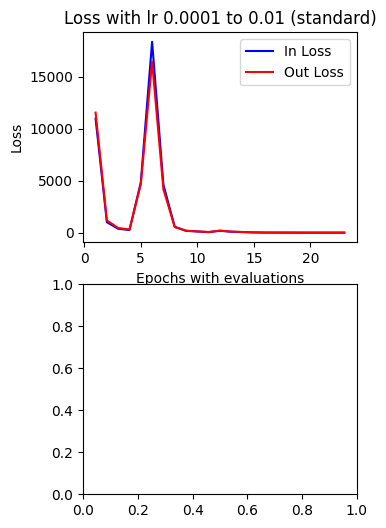

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

eval_epochs = range(1, len(in_loss_standard_hist[0]) + 1)

plt.figure(figsize=(12, 6))
for i, (lr_base, lr_max) in enumerate(lr_to_test):
    # Plot for standard
    plt.subplot(2, len(lr_to_test), i + 1)
    plt.plot(eval_epochs, in_loss_standard_hist[i], 'b', label='In Loss')
    plt.plot(eval_epochs, out_loss_standard_hist[i], 'r', label='Out Loss')
    plt.title(f'Loss with lr {lr_base} to {lr_max} (standard)')
    plt.xlabel('Epochs with evaluations')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for normalized
    plt.subplot(2, len(lr_to_test), len(lr_to_test) + i + 1)
    plt.plot(eval_epochs, in_loss_normalized_hist[i], 'b', label='In Loss')
    plt.plot(eval_epochs, out_loss_normalized_hist[i], 'r', label='Out Loss')
    plt.title(f'Loss with lr {lr_base} to {lr_max} (normalized)')
    plt.xlabel('Epochs with evaluations')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


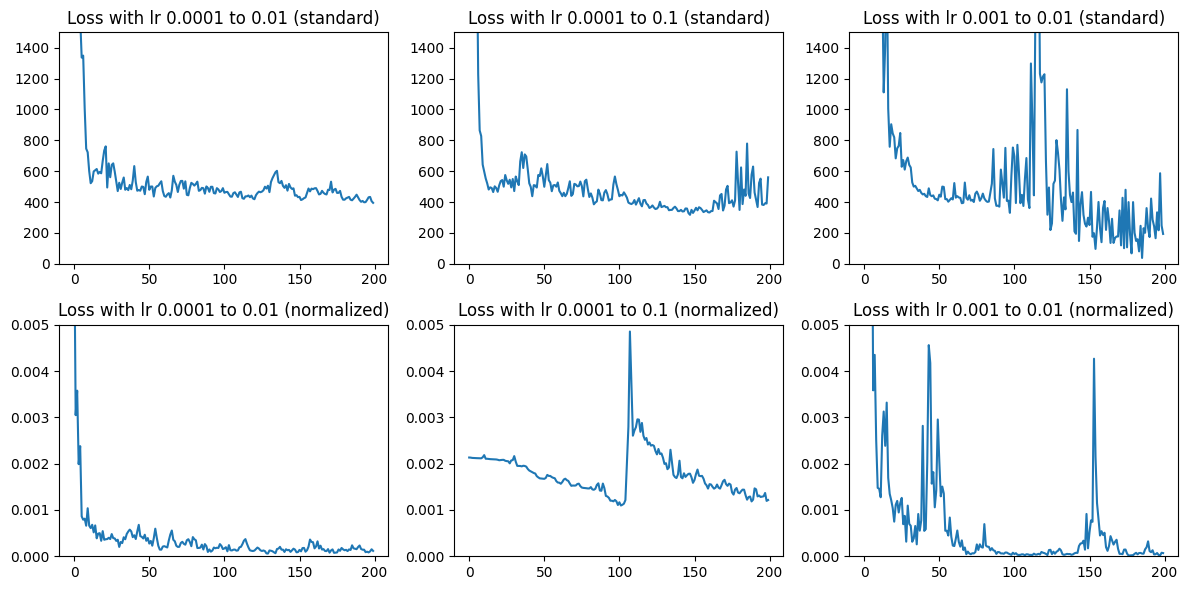

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

eval_epochs = range(1, len(in_acc_standard_hist[0]) + 1)

plt.figure(figsize=(12, 6))
for i, (lr_base, lr_max) in enumerate(lr_to_test):
    # Plot for standard
    plt.subplot(2, len(lr_to_test), i + 1)
    plt.plot(eval_epochs, in_acc_standard_hist[i], 'b', label='In Acc')
    plt.plot(eval_epochs, out_loss_standard_hist[i], 'r', label='Out Acc')
    plt.title(f'Acc with lr {lr_base} to {lr_max} (standard)')
    plt.xlabel('Epochs with evaluations')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot for normalized
    plt.subplot(2, len(lr_to_test), len(lr_to_test) + i + 1)
    plt.plot(eval_epochs, in_acc_normalized_hist[i], 'b', label='In Acc')
    plt.plot(eval_epochs, out_acc_normalized_hist[i], 'r', label='Out Acc')
    plt.title(f'Acc with lr {lr_base} to {lr_max} (normalized)')
    plt.xlabel('Epochs with evaluations')
    plt.ylabel('Acc')
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_standard_acc.npy', full_standard_acc)
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_normalized_acc.npy', full_normalized_acc)
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_standard_loss.npy', full_standard_loss)
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_normalized_loss.npy', full_normalized_loss)

a = np.load('/content/gdrive/MyDrive/license_plate/models/full_normalized_acc.npy')
print(a)

### Experiment : Removing layers from mobilenet


Explain what has been done: ...

In [ ]:
import torch
import torch.nn as nn

# Function to create the modified classifier
def create_custom_classifier(input_features, hidden_units, output_features):
    classifier = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Dropout(0.0),
        nn.Linear(hidden_units, output_features),
    )
    return classifier

# Function to create a new MobileNetV3 model with modified layers
def get_modified_mobilenet(num_layers_to_remove):
    if not (1 <= num_layers_to_remove <= 12):
        raise ValueError("num_layers_to_remove should be between 1 and 12.")

    # Load a pre-trained MobileNetV3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)

    # Remove some layers from the features module
    model.features = nn.Sequential(*list(model.features.children())[:-num_layers_to_remove])

    # Update the input size of the custom classifier to match the output size of the modified features module
    input_features = model.features[-1].out_channels
    model.classifier = create_custom_classifier(input_features, hidden_units=100, output_features=4)

    # Number of layers you want to fine-tune
    layers_of_classifier = len(model.classifier)

    # Get all the parameters from the model as a list
    parameters = list(model.parameters())

    # The total number of layers is the length of the parameters list
    number_of_layers = len(parameters)

    # Calculate the number of pretrained layers (all except the last 'layers_of_classifier')
    pretrained_layers = number_of_layers - layers_of_classifier

    # Freeze the parameters of the pretrained base layers
    for param in parameters[:-layers_of_classifier]:
        param.requires_grad = False

    # Unfreeze the parameters of the last 'layers_of_classifier' layers
    for param in parameters[-layers_of_classifier:]:
        param.requires_grad = True

    # Set the model to evaluation mode if not training
    model.eval()
    return model

# # Get the modified model
# modified_model = get_modified_mobilenet()

# # Print the modified model architecture
# print(modified_model)

# check_requires_grad(modified_model)

In [ ]:
# Define model, loss function, optimizers, and schedulers
model = get_modified_mobilenet(num_layers_to_remove=3)

trained_model = train_full_model(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Input dimensions to custom classifier: 160
Starting training with decoder...


 20%|██        | 1/5 [00:02<00:11,  2.93s/it]

Epoch 1, In-sample Loss: 0.2146, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.2183, Out-sample Accuracy: 0.0000


 60%|██████    | 3/5 [00:05<00:03,  1.92s/it]

Epoch 3, In-sample Loss: 0.1101, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.1203, Out-sample Accuracy: 0.0000


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 5, In-sample Loss: 0.0212, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0324, Out-sample Accuracy: 0.0000
Decoder training completed.
Starting full model training with cyclic LR ...


 20%|██        | 1/5 [00:03<00:14,  3.61s/it]

Epoch 1, In-sample Loss: 0.0207, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0316, Out-sample Accuracy: 0.0000


 60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

Epoch 3, In-sample Loss: 0.0106, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0214, Out-sample Accuracy: 0.0000


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


Epoch 5, In-sample Loss: 0.0049, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0108, Out-sample Accuracy: 0.0000
Full model training completed.
Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/5 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


 20%|██        | 1/5 [00:02<00:09,  2.35s/it]

Epoch 1, In-sample Loss: 0.0040, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0096, Out-sample Accuracy: 0.0000


 40%|████      | 2/5 [00:03<00:04,  1.47s/it]

Adjusting learning rate of group 0 to 2.5000e-05.
Adjusting learning rate of group 0 to 1.2500e-05.


 60%|██████    | 3/5 [00:05<00:03,  1.90s/it]

Epoch 3, In-sample Loss: 0.0037, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0093, Out-sample Accuracy: 0.0000


 80%|████████  | 4/5 [00:06<00:01,  1.49s/it]

Adjusting learning rate of group 0 to 6.2500e-06.
Adjusting learning rate of group 0 to 3.1250e-06.


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]

Epoch 5, In-sample Loss: 0.0036, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0093, Out-sample Accuracy: 0.0000


### Plot data

torch.Size([224, 224, 3])


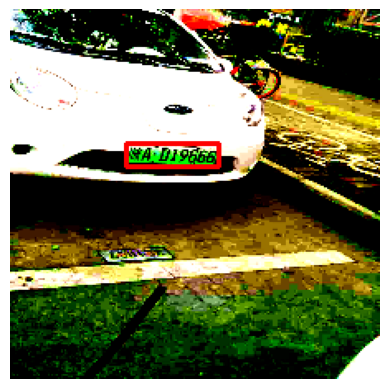

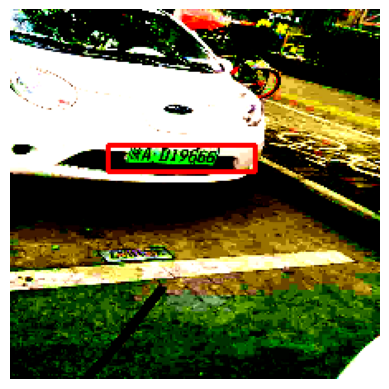

In [38]:
#print a trainset with predicted label
# train_loader = DataLoader(data_loader, batch_size=1, shuffle=True, num_workers=1)
model.to(device)
model.eval()
train_iter = iter(train_loader)

batch = next(train_iter)

X_batch, y_batch, _ = batch

image = batch[0][5]
labels = batch[1][5]

# Get predicted labels
X_batch = X_batch.permute(0,3,1,2).to(device)
pred = model(X_batch)
print(image.shape)
plot_img_and_boundingbox(image, labels,224)
plot_img_and_boundingbox(image, pred[0],224)

('/content/gdrive/MyDrive/license_plate/danish_license/train/0-0_0-271&735_545&677-0-0.jpg', '/content/gdrive/MyDrive/license_plate/danish_license/train/0-0_0-494&760_724&650-0-0.jpg', '/content/gdrive/MyDrive/license_plate/danish_license/train/0-0_0-175&727_358&632-0-0.jpg', '/content/gdrive/MyDrive/license_plate/danish_license/train/0-0_0-272&416_434&370-0-0.jpg', '/content/gdrive/MyDrive/license_plate/danish_license/train/0-0_0-198&516_334&459-0-0.jpg', '/content/gdrive/MyDrive/license_plate/danish_license/train/0-0_0-530&772_926&681-0-0.jpg', '/content/gdrive/MyDrive/license_plate/danish_license/train/0-0_0-535&524_884&434-0-0.jpg', '/content/gdrive/MyDrive/license_plate/danish_license/train/0-0_0-278&639_530&572-0-0.jpg')
label: tensor([0.1071, 0.6875, 0.2232, 0.5982])
torch.Size([224, 224, 3])


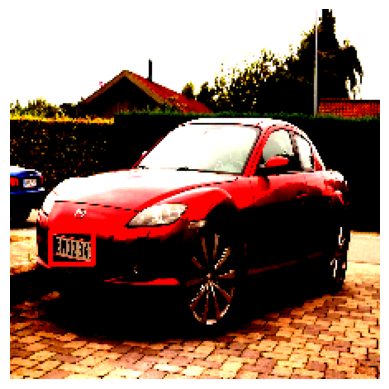

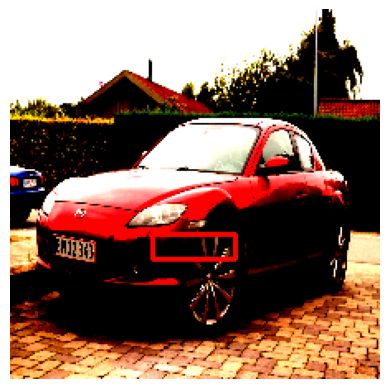

In [69]:
#print a trainset with predicted label
# train_loader = DataLoader(data_loader, batch_size=1, shuffle=True, num_workers=1)
model.to(device)
train_iter = iter(train_danish_loader)

batch = next(train_iter)

X_batch, y_batch, img_names = batch
print(img_names)
# for i in range(13):
image = batch[0][2]
labels = batch[1][2]
print(f"label: {labels}")

# Get predicted labels
X_batch = X_batch.permute(0,3,1,2).to(device)
pred = model(X_batch)
print(image.shape)



plot_img_and_boundingbox(image, labels,224)
plot_img_and_boundingbox(image, pred[0],224)

In [ ]:
# # Print a validation image with its predicted labels

# validationloader = DataLoader(test_loader, batch_size=1, shuffle=True, num_workers=1)

# validationloader_iter = iter(validationloader)

# batch = next(validationloader_iter)

# X_batch, y_batch, _ = batch
# print(X_batch.shape)
# print(y_batch.shape)

# image = batch[0][0]
# labels = batch[1][0]

# # Get predicted labels
# X_batch = X_batch.permute(0,3,1,2).to(device)
# print(X_batch.shape)
# pred = model(X_batch)

# plot_img_and_boundingbox(image, labels)

In [ ]:
# plot_img_and_boundingbox(image,pred[0])
# print(pred)
# print(calculate_true_positives_in_batch(labels.view(1,4),pred[0].view(1,4))) # Need to change view since we dont have batch